In [1]:
import pandas as pd

import io
import os
import sys
print(sys.path)

## You will change this to whatever the locaiton of the micronetworks package is in your computer
sys.path.append(r'/home/pedrotorres/Desktop/Projects/micronetworks')
print(sys.path)
import micronetworks
from micronetworks.networkstats import *


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

['/home/pedrotorres/Desktop/Projects/micronetworks', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python38.zip', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8/lib-dynload', '', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages']
['/home/pedrotorres/Desktop/Projects/micronetworks', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python38.zip', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8/lib-dynload', '', '/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages', '/home/pedrotorres/Desktop/Projects/micronetworks']


### Will be working with data that is on my computer, but information here should be enough to get anyone started with their own data. 

In [2]:
dir_met='/home/pedrotorres/Desktop/Projects/metabolomics_10272022/'
xls = pd.ExcelFile(dir_met+'PR042-22_Persephone_Feces_Microbiome_CDT_102122.xlsx')
metabol_df = pd.read_excel(xls, 'PR042-22_all_data_vertical')

# I do not like the spacing and charcters in the columns so will change that for easier analysis later
metabol_df = metabol_df.rename(columns={'Sample Name':'sample_name','Component Name':'Component_Name',
                           'conc (ug/g wet weight)':'wet_weight_ug/g','%dry weight ':'percent_dry_weight',
                          'conc (ug/g dry weight)':'dry_weight_ug/g'})

# The mapping file for this is the same as what is on the Plate_1_Metadata.xlsx
# Convwersation with Bryce:  Sample_Name 3005 or 3008 in the metabolomics file (Pr04_22..) it is  
# PBT-03005 and PBT-03008 in our Plate_1_metadata.xlsx
# This means we are simply adding a PBT-0 to the front of all sample_names. I checked afew manually and it seems to be the case
# I will double check once i merge with the metadata and make sure we are not missing anything. 
metabol_df['sample_name'] = 'PBT-0'+metabol_df['sample_name'].astype(str)

# also realized that the only sample that does not have a 0 infront of thir name (based on the metabolomics) is sample PBT-3040
# i will manually change this

metabol_df = metabol_df.set_index('sample_name').rename(index={'PBT-03040':'PBT-3040'}).reset_index()
metabol_df.head(1)

,sample_name,Component_Name,wet_weight_ug/g,percent_dry_weight,dry_weight_ug/g
0,PBT-03005,2-methylbutyrate,nq,0.066357,nq


In [3]:
# Let's check to make sure my assumtion above makes sense. 
## There are 50 samples that we got metabolomics from

sample_name_metabolomics = metabol_df['sample_name']
sample_name_metabolomics = pd.DataFrame(sample_name_metabolomics.drop_duplicates())
sample_name_metabolomics.shape

metadata_file = pd.read_csv('/home/pedrotorres/Desktop/Projects/hmo_clusters/Plate_1_Metadata.xlsx.csv')
metadata_file

metabolomics_metadata = pd.merge(sample_name_metabolomics,metadata_file, left_on='sample_name', right_on='BabyBio PBT', how = 'left')
metabolomics_metadata.shape

(50, 12)

In [4]:
# douple check row names are same 
print(sample_name_metabolomics.shape)
print(metabolomics_metadata.shape)

# perfect it matched after we manually changed that naem above. 

(50, 1)
(50, 12)


In [5]:
metabol_df.replace({'nq': 0.0}, inplace=True)
metabol_df_pivot = metabol_df.pivot(index='sample_name', values = 'dry_weight_ug/g', columns = 'Component_Name')
metabol_df_pivot_clr = mr_clr(metabol_df_pivot)
metabol_df_pivot_clr.head(1)

Component_Name,2-methylbutyrate,3-hydroxybenzoate,3-hydroxyhippurate,3-hydroxyphenylpropionate,3-methylindole,4-Ethylphenylsulfate,4-ethylphenol,4-hydroxyphenylacetate,4-hydroxyphenylacrylate,4-hydroxyphenyllactate,...,propionate,putrescine,serotonin,trimethylamine (TMA),tryptamine,tryptophan,tyramine,tyrosine,ursodeoxycholate,valerate
sample_name,,,,,,,,,,,,,,,,,,,,,
PBT-03005,-0.633454,-0.633454,-3.107344,-0.633454,-3.799605,-0.633454,-0.633454,-0.633454,-2.866419,2.371922,...,3.233888,3.241656,-0.633454,2.157329,-5.790503,1.475842,3.047851,2.285168,-1.836726,-0.633454


## Add species

In [6]:
# You may do as you would like. I jsut tried to clean up my data a bit and for this I jsut focused on Bifidobacterium taxa
species = pd.read_csv('~/Desktop/Projects/hmo_clusters/full_species_abun_pivot.txt', sep='\t')
species_clr = mr_clr(species.set_index('sample_id'))
##Remove low prevelance species . meaning i do not want to include species that are only present 2 times. 
prev = pd.DataFrame(prevelance(species.set_index('sample_id')))
prevlist = list(prev[prev[0]<5].reset_index()['index'])
species_clr = species_clr.drop(prevlist, axis=1)
all_tax  = pd.DataFrame(species_clr.columns).rename(columns={0:'taxa'})
all_bifido = all_tax[all_tax['taxa'].str.contains("Bifido")]
all_bifido = list(all_bifido['taxa'])

species_clr_all_bif = species_clr[all_bifido]


In [7]:
species_metabolites = pd.merge(species_clr_all_bif.reset_index(),metabol_df_pivot_clr.reset_index(), left_on='sample_id', right_on='sample_name')
species_metabolites = species_metabolites.set_index('sample_id')
species_metabolites = species_metabolites.drop(columns='sample_name')

## Add immune

In [8]:
immune = pd.read_csv('/home/pedrotorres/Desktop/Projects/eve_immune_110722/eve_replaced_oors.tsv', sep='\t')
immune = immune.drop(columns=['my_baby_biome','eve_sample_name','Conc (ug/mL)'])
immune = immune.fillna(0)
immune_clr = mr_clr(immune.set_index('PBT'))
immune_clr.head(1)

,sCD40L,EGF,Eotaxin,FGF-2,FLT-3L,Fractalkine,G-CSF,GM-CSF,GROα,IFN-α2,...,LIF,MCP-2,MCP-4,MIP-1δ,SCF,SDF-1α+β,TARC,TPO,TRAIL,TSLP
PBT,,,,,,,,,,,,,,,,,,,,,
PBT-03005,1.955234,-2.596591,0.95504,1.856699,-0.974249,2.547197,0.128627,-2.797261,-0.177667,0.274844,...,0.647928,0.98981,0.080688,-0.425683,-2.386519,4.079052,-2.195464,0.174373,-0.543466,-1.439138


In [9]:
species_metabolites_immune = pd.merge(species_metabolites.reset_index(), immune_clr.reset_index(), 
                                      left_on='sample_id', right_on='PBT')
species_metabolites_immune = species_metabolites_immune.set_index('sample_id').drop(columns=['PBT'])
species_metabolites_immune.head(1)

,Bifidobacterium adolescentis,Bifidobacterium angulatum,Bifidobacterium bifidum,Bifidobacterium breve,Bifidobacterium catenulatum,Bifidobacterium dentium,Bifidobacterium imperatoris,Bifidobacterium infantis,Bifidobacterium kashiwanohense,Bifidobacterium kashiwanohense_A,...,LIF,MCP-2,MCP-4,MIP-1δ,SCF,SDF-1α+β,TARC,TPO,TRAIL,TSLP
sample_id,,,,,,,,,,,,,,,,,,,,,
PBT-03005,-0.324178,-0.324178,-0.324178,-0.324178,-0.324178,-0.324178,-0.324178,-0.324178,-0.324178,-0.324178,...,0.647928,0.98981,0.080688,-0.425683,-2.386519,4.079052,-2.195464,0.174373,-0.543466,-1.439138


In [10]:
# get correlation p value matrix
pearson_species_metabolites_immune = calculate_corrcoef_pvalues(species_metabolites_immune,pearsonr)

In [11]:
pearson_species_metabolites_immune.head(1)

,Bifidobacterium adolescentis,Bifidobacterium angulatum,Bifidobacterium bifidum,Bifidobacterium breve,Bifidobacterium catenulatum,Bifidobacterium dentium,Bifidobacterium imperatoris,Bifidobacterium infantis,Bifidobacterium kashiwanohense,Bifidobacterium kashiwanohense_A,...,LIF,MCP-2,MCP-4,MIP-1δ,SCF,SDF-1α+β,TARC,TPO,TRAIL,TSLP
Bifidobacterium adolescentis,1.0,0.000677,0.081116,0.044901,0.007684,0.625895,0.018478,0.039165,0.03635,0.002693,...,0.996148,0.717478,0.466522,0.729748,0.017884,0.663082,0.301201,0.591382,0.934514,0.922445


# Might erase here but will try inverse covariance and see what happens

In [179]:
import numpy as np
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix

array([[-6.01790874e-01,  2.56864850e+00,  2.25027057e-01, ...,
         1.58030453e+00,  1.11132352e+00, -3.13389919e-01],
       [-7.84003994e-01, -3.55657251e-01,  1.35616689e+00, ...,
         6.34724390e-01, -8.59943442e-01,  1.55898350e+00],
       [ 1.10561007e+00,  7.36465233e-02,  8.69382259e-02, ...,
         1.17312842e+00,  7.24390609e-01, -8.93568304e-01],
       ...,
       [-9.43851959e-01, -3.66489582e-01, -3.00448272e-01, ...,
        -1.42854491e-03,  4.97751656e-01,  1.55375164e-02],
       [-1.72165762e+00,  2.22312749e+00,  1.59745891e+00, ...,
         1.06890577e+00, -1.22471966e+00, -1.13650280e+00],
       [ 2.05889029e+00, -7.64338404e-02,  3.16978060e-03, ...,
         3.56962933e-01, -5.86065320e-01,  8.46862580e-01]])

In [226]:
from sklearn import covariance
from sklearn.covariance import GraphicalLasso

# using this tutorial https://towardsdatascience.com/machine-learning-in-action-in-finance-using-graphical-lasso-to-identify-trading-pairs-in-fa00d29c71a7
df = species_metabolites_immune
edge_model = covariance.GraphicalLassoCV(cv=7)
# df /= df.std(axis=0)
df -= df.mean(axis=0)
df /= df.std(axis=0)
edge_model.fit(df)
# #the precision(inverse covariance) matrix that we want
p = edge_model.precision_

/home/pedrotorres/miniconda3/envs/qiime2-2022/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [237]:
col = species_metabolites_immune.columns
cols = pd.Series(col)
p = pd.DataFrame(p, columns=cols, index=cols)
p

,Bifidobacterium adolescentis,Bifidobacterium angulatum,Bifidobacterium bifidum,Bifidobacterium breve,Bifidobacterium catenulatum,Bifidobacterium dentium,Bifidobacterium imperatoris,Bifidobacterium infantis,Bifidobacterium kashiwanohense,Bifidobacterium kashiwanohense_A,...,LIF,MCP-2,MCP-4,MIP-1δ,SCF,SDF-1α+β,TARC,TPO,TRAIL,TSLP
Bifidobacterium adolescentis,1.547938,-0.035449,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,0.0,-0.000000,0.000000,-0.000000,-0.093273,-0.000000,0.000000,0.000000,-0.000000,-0.000000
Bifidobacterium angulatum,-0.035449,1.639908,-0.000000,0.000000,-0.254245,-0.000000,-0.000000,-0.000000,-0.000000,-0.064916,...,-0.0,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
Bifidobacterium bifidum,-0.000000,-0.000000,1.408500,-0.146994,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.083379,...,-0.0,0.212535,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000
Bifidobacterium breve,-0.000000,0.000000,-0.146994,2.303012,-0.000000,0.000000,-0.000000,-0.566075,-0.000000,-0.000000,...,-0.0,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.015537,-0.000000
Bifidobacterium catenulatum,-0.000000,-0.254245,-0.000000,-0.000000,1.731051,-0.055783,-0.000000,-0.000000,-0.311466,-0.054927,...,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SDF-1α+β,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.0,-0.005954,-0.000000,0.000000,-0.000000,1.566344,-0.000000,0.000000,0.000000,-0.000000
TARC,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,...,0.0,-0.000000,-0.000000,-0.240451,-0.000000,-0.000000,1.734559,-0.066896,0.000000,-0.000000
TPO,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,...,-0.0,-0.000000,-0.000000,-0.325723,-0.001223,0.000000,-0.066896,1.971548,0.000000,-0.264046
TRAIL,-0.000000,-0.000000,-0.000000,0.015537,0.000000,0.000000,-0.046978,0.000000,0.028185,0.000000,...,0.0,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,1.419401,-0.000000


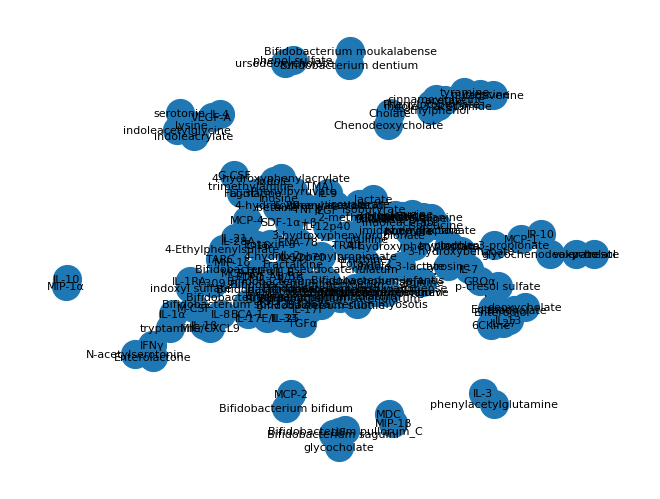

In [238]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added 
#youre threshold here can dictate what happens below
networkset=networkset.loc[ (abs(networkset['value']) > 0.2) &  (networkset['var1'] != networkset['var2']) ]

nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]
#build the graph using networkx lib
# G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
# pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)

# nx.draw(G, pos=pos)



# nx.draw_networkx_labels(G, pos=pos)
# plt.show()



G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.1))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True,  node_size=400,  linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.1))


<AxesSubplot:>

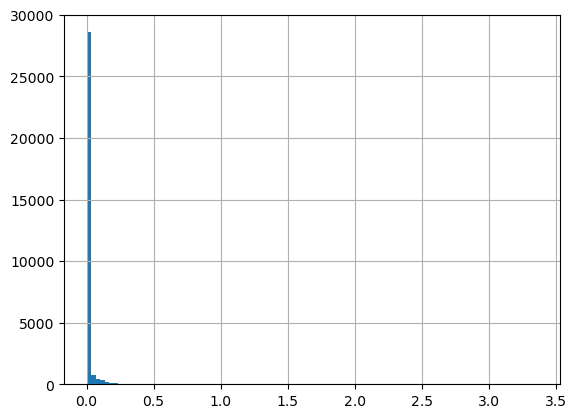

In [239]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
abs(links['value']).hist(bins=100)

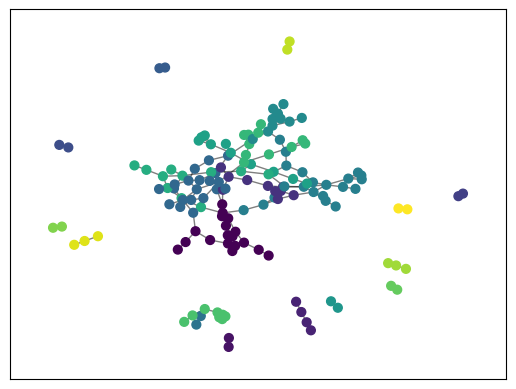

In [240]:
partition = community_louvain.best_partition(G)
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [241]:
partition = community_louvain.best_partition(G)
partition_lovian = pd.DataFrame(partition.items(), columns=['Name', 'Values'])
partition_lovian[partition_lovian['Name'].str.contains('Bifido')].sort_values('Values')

,Name,Values
0,Bifidobacterium adolescentis,0
20,Bifidobacterium kashiwanohense_A,0
15,Bifidobacterium kashiwanohense,0
13,Bifidobacterium reuteri,0
10,Bifidobacterium infantis,0
9,Bifidobacterium breve,0
11,Bifidobacterium longum,0
5,Bifidobacterium catenulatum,0
4,Bifidobacterium angulatum,0
3,Bifidobacterium sp002742445,0


In [242]:
partition_lovian[partition_lovian['Values'] ==1]

,Name,Values
7,Bifidobacterium bifidum,1
8,MCP-2,1


In [243]:
binfantis = permutation_community_cluster('Bifidobacterium infantis', G, 800, 50)


In [244]:
search_for = binfantis

In [245]:
search_for

['Bifidobacterium adolescentis',
 'Bifidobacterium pseudocatenulatum',
 'Bifidobacterium ruminantium',
 'Bifidobacterium sp002742445',
 'Bifidobacterium angulatum',
 'Bifidobacterium catenulatum',
 'Bifidobacterium merycicum',
 'Bifidobacterium breve',
 'Bifidobacterium infantis',
 'Bifidobacterium longum',
 'Bifidobacterium reuteri',
 'Bifidobacterium kashiwanohense',
 'Bifidobacterium kashiwanohense_A',
 'Bifidobacterium sp012932675']

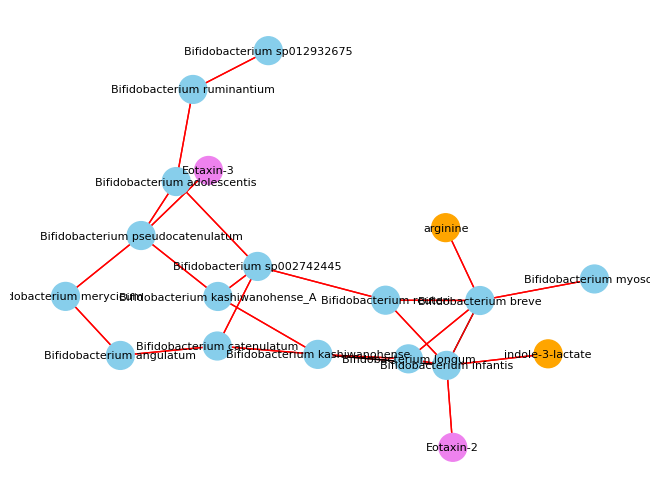

In [246]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.2) &  (networkset['var1'] != networkset['var2']) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) | (networkset['var2'].str.contains('|'.join(search_for)))]


nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.1))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


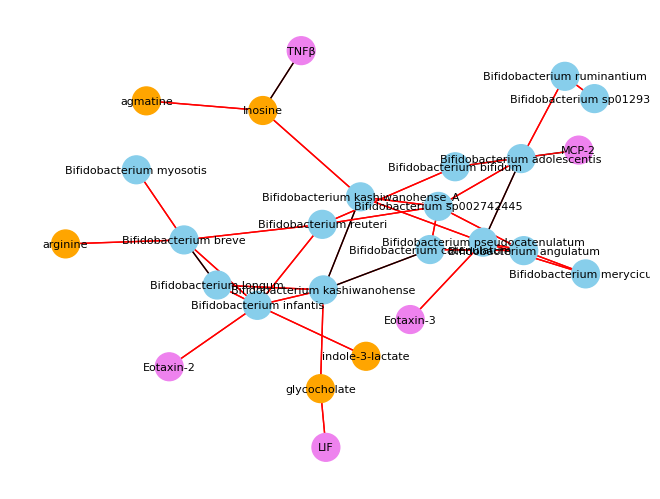

In [178]:
p = pd.DataFrame(p, columns=cols, index=cols)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
networkset=links

## added
networkset=networkset.loc[ (abs(networkset['value']) > 0.18) &  (networkset['var1'] != networkset['var2']) ]

colors = networkset['value'].apply(lambda x: 'red' if x <0 else 'black') 
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) | (networkset['var2'].str.contains('|'.join(search_for)))]


nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]

## added
############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2',edge_attr='value')

# nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.1))
nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


In [158]:
print(G.degree)

[('Bifidobacterium adolescentis', 3), ('Bifidobacterium pseudocatenulatum', 4), ('Bifidobacterium ruminantium', 2), ('Bifidobacterium sp002742445', 4), ('Bifidobacterium angulatum', 2), ('Bifidobacterium catenulatum', 3), ('Bifidobacterium merycicum', 2), ('Bifidobacterium breve', 5), ('Bifidobacterium infantis', 6), ('Bifidobacterium longum', 3), ('Bifidobacterium myosotis', 1), ('Bifidobacterium reuteri', 3), ('arginine', 1), ('Bifidobacterium kashiwanohense', 4), ('indole-3-lactate', 1), ('Eotaxin-2', 1), ('Bifidobacterium kashiwanohense_A', 3), ('Eotaxin-3', 1), ('Bifidobacterium sp012932675', 1), ('Inosine', 1), ('agmatine', 1), ('glycocholate', 1), ('LIF', 1)]


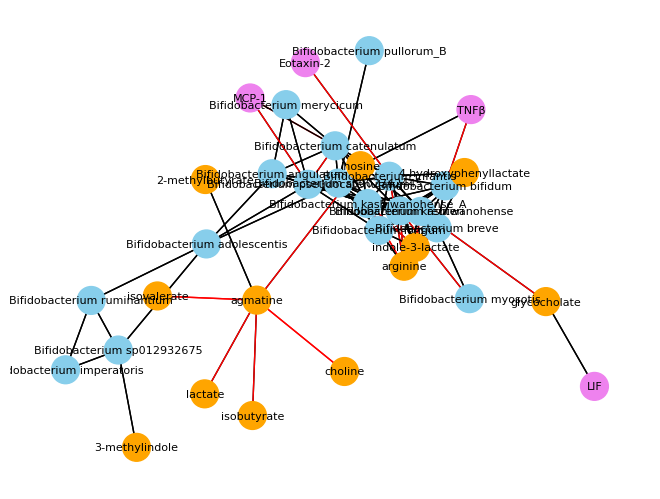

In [149]:
"""
Here we will once again focus on plotting based on both correlation coefficient and pvalue but with the addition that we will
now do a multiple test pvalue adjustment. Here I will add colors to the nodes to make them stand out if metabolite, taxa or immune
"""

search_for = binfantis

networkset = merge_corr_coef_pvalue_corr(species_metabolites_immune, pearson_species_metabolites_immune, corr_coef=0.3, pval=0.05)

# Change colors of edges depending of whether thereis a negative correlation or  positive correlation
colors = networkset['corr_coeff'].apply(lambda x: 'red' if x <0 else 'black') 


# only focus on bacteria ofinterest
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) | (networkset['var2'].str.contains('|'.join(search_for)))]

### this is addiitonal filtering done so we only focus on our subset df features of interest i.e. passed corr_coef and pvalue_corr
### thresholds. Also have the addition of filtering based on bifido. Will likely want ot change this later. 


nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]
## added



############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors
# change names to make betetr figure


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2')

nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))


# will remove above here

# making networks

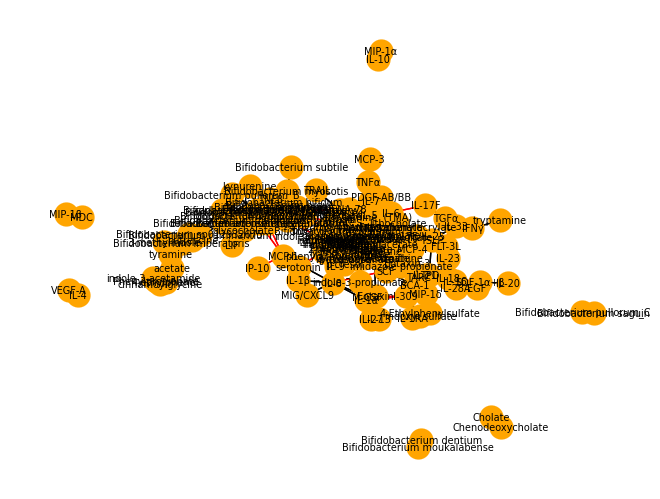

In [12]:
networkset = merge_corr_coef_pvalue_corr(species_metabolites_immune, pearson_species_metabolites_immune, corr_coef=0.3, pval=0.05)
nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]

# Change colors of edges depending of whether thereis a negative correlation or  positive correlation
colors = networkset['corr_coeff'].apply(lambda x: 'red' if x <0 else 'black') 


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2')

nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color='orange', node_size=300, edge_color=colors, linewidths=0.1, font_size=7,pos=nx.spring_layout(G, k=.1))


### Let us color based on categorical feature (taxa, metabolite , immune) 

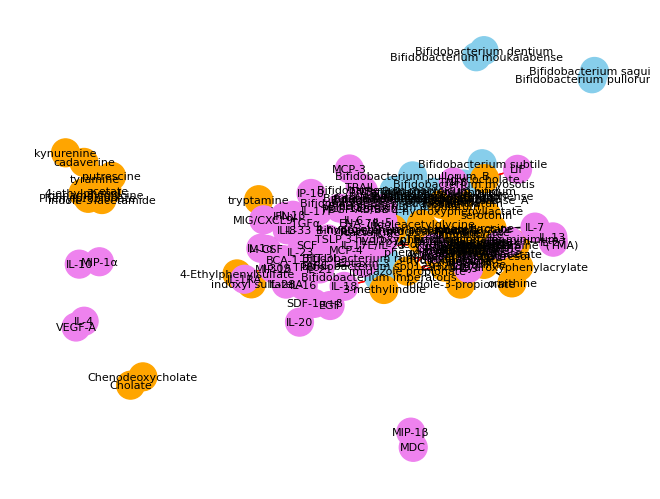

In [13]:
nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]
## added


# Change colors of edges depending of whether thereis a negative correlation or  positive correlation
colors = networkset['corr_coeff'].apply(lambda x: 'red' if x <0 else 'black') 

############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors
# change names to make betetr figure
G=nx.from_pandas_edgelist(networkset, 'var1', 'var2')

nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=.1))


## Create modules in general 

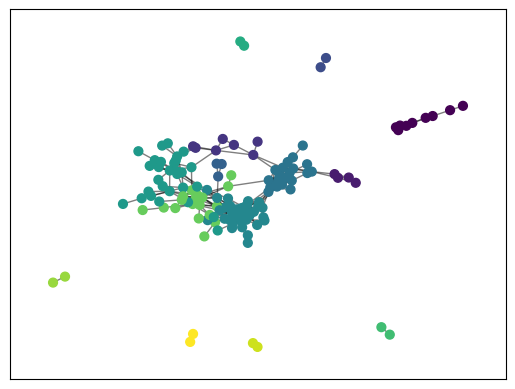

In [14]:
partition = community_louvain.best_partition(G,random_state=100)
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [15]:
# explore a bit 
partition = community_louvain.best_partition(G)
partition_lovian = pd.DataFrame(partition.items(), columns=['Name', 'Values'])
partition_lovian[partition_lovian['Name'].str.contains('Bifido')].sort_values('Values')

,Name,Values
0,Bifidobacterium adolescentis,0
33,Bifidobacterium pullorum_B,0
32,Bifidobacterium subtile,0
18,Bifidobacterium myosotis,0
17,Bifidobacterium kashiwanohense,0
13,Bifidobacterium reuteri,0
12,Bifidobacterium longum,0
10,Bifidobacterium breve,0
9,Bifidobacterium bifidum,0
11,Bifidobacterium infantis,0


In [63]:
binfantis = permutation_community_cluster('Bifidobacterium infantis', G, 800, 50)


## Focus on a specific feature and its community - in this case B. infantis. Selecting modules can have a bit of a randomness in its calculation. Weaker features will appear and dissapear with each iteration. Let's use a permutational approach to get community confidence

In [16]:
binfantis = permutation_community_cluster('Bifidobacterium infantis', G, 800, 50)


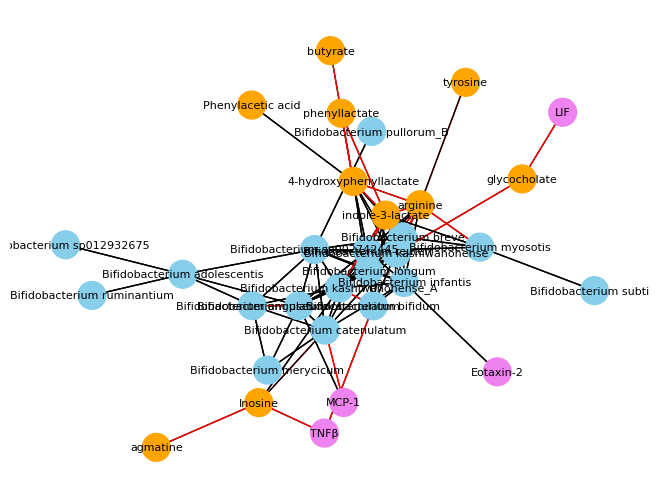

In [19]:
"""
Here we will once again focus on plotting based on both correlation coefficient and pvalue but with the addition that we will
now do a multiple test pvalue adjustment. Here I will add colors to the nodes to make them stand out if metabolite, taxa or immune
"""

search_for = binfantis

networkset = merge_corr_coef_pvalue_corr(species_metabolites_immune, pearson_species_metabolites_immune, corr_coef=0.3, pval=0.05)

# Change colors of edges depending of whether thereis a negative correlation or  positive correlation
colors = networkset['corr_coeff'].apply(lambda x: 'red' if x <0 else 'black') 


# only focus on bacteria ofinterest
networkset = networkset[(networkset['var1'].str.contains('|'.join(search_for))) | (networkset['var2'].str.contains('|'.join(search_for)))]

### this is addiitonal filtering done so we only focus on our subset df features of interest i.e. passed corr_coef and pvalue_corr
### thresholds. Also have the addition of filtering based on bifido. Will likely want ot change this later. 


nodes = list(networkset['var1'].unique())
edges = [tuple(i) for i in networkset[['var1','var2']].values]
## added



############# ADD COLORS TO THE FEATURE NODES ##########
###################################################
metabol = pd.DataFrame(metabol_df_pivot_clr.columns).rename(columns = {'Component_Name':'features'})
species = pd.DataFrame(species_clr.columns).rename(columns = {0:'features'})
immune = pd.DataFrame(immune_clr.columns).rename(columns = {0:'features'})

metabol['type']='metabolite'
species['type']='taxa'
immune['type']='immune'

multi_omics_feature_info = pd.concat([metabol,species, immune])
node_features = pd.DataFrame(nodes).rename(columns = {0:'features'})
node_features = pd.merge(node_features, multi_omics_feature_info, on='features')
node_colors = node_features['type'].apply(lambda x: 'skyblue' if x == 'taxa' else ('orange' if x=='metabolite' else 'violet')) 
node_colors
# change names to make betetr figure


G=nx.from_pandas_edgelist(networkset, 'var1', 'var2')

nx.draw(G,edgelist = edges, nodelist=nodes, with_labels=True, node_color=node_colors, node_size=400, edge_color=colors, linewidths=1, font_size=8,pos=nx.spring_layout(G, k=0.5))
